In [1]:
# SET THE WORKING DIRECTORY FOR THIS ASSIGNMENT

%cd 'D:\Masters\S1Class\AdvResMeth8160\Hw02'

[WinError 123] The filename, directory name, or volume label syntax is incorrect: "'D:\\Masters\\S1Class\\AdvResMeth8160\\Hw02'"
d:\Masters\S1Class\AdvResMeth8160\Hw02


In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
gpu_name = torch.cuda.get_device_name(0)
print("GPU at index 0:", gpu_name)
print(torch.__version__)

cuda:0
GPU at index 0: NVIDIA GeForce GTX 1650
2.0.0


In [2]:
# IMPORT NEEDED MODULES

import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

RNN

In [101]:
class TrafficDataset(Dataset):
  def __init__(self, pkl_path, window, horizon):
    self.pkl_path = pkl_path
    self.window = window
    self.horizon = horizon
    


   # RESHAPE THE DATAFRAME
    df = pd.read_pickle(self.pkl_path)
    reshaped_df = pd.DataFrame()
    df['time'] = df['time'].apply(lambda x: int(datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f").timestamp()))
    reshaped_df['TIME'] = df.time.unique()
    for seg in df.segmentID.unique():
        column =df[df['segmentID'] == seg][['time','TrafficIndex_GP']].drop_duplicates(subset=['time'])
        column.columns = ['TIME', str(seg)]
        reshaped_df = reshaped_df.join(column.set_index('TIME'), on='TIME')
    reshaped_df = reshaped_df.set_index('TIME')
    reshaped_df = reshaped_df.fillna(0)
    # print(reshaped_df)


    self.inputs = []
    self.outputs = []
    times = reshaped_df.index
    
    for column in reshaped_df.columns:
       for t in range(0, len(times) - (self.window + self.horizon)):
          w = times[t : t + self.window]
          x_list = []
          for i in range (0, self.window):
            x_list.append(int(column))
          x = x_list
          y = reshaped_df[str(column)][t: t + self.window].values
          wxy_cat = np.dstack([w,x,y])
          self.inputs.append(wxy_cat)
          z = reshaped_df[str(column)][self.window + t: self.window + t + self.horizon].values
          self.outputs.append(z)
    print(len(self.inputs))
    print(len(self.outputs))
       

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self,idx):
    X = torch.tensor(self.inputs[idx])
    y=torch.tensor(self.outputs[idx])
    return {'inputs':X,'outputs':y}

class ToTensor(object):
    def __call__(self, bs,window, horizon, sample):
        input, output = sample['inputs'], sample['outputs']

        return {'inputs': torch.tensor(np.array(input),dtype=torch.float32),
                'outputs': torch.tensor(np.array(output),dtype=torch.float32)}

In [6]:
window = 36; horizon = 12
traffic_obj_train = TrafficDataset('D:\\Masters\\S1Class\\AdvResMeth8160\\Hw02\\tps_df.pkl', window, horizon)

In [3]:
class MyRNNCell(nn.Module):
    def __init__(self,input_size, hidden_size, bias=True):
        super(MyRNNCell,self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias 
        self.x2h = nn.Linear(input_size,hidden_size, bias=self.bias)
        self.h2h = nn.Linear(hidden_size,hidden_size,bias=self.bias)
        self.nonlinearity = nn.ReLU()

    def forward(self,x):
        h0 = torch.zeros(x.size(0), self.hidden_size).to(device)
        hy = (self.x2h(x) + self.h2h(h0))
        hy = self.nonlinearity(hy)
        return hy 

class MyRNN(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers,output_size, bias=True):
        super(MyRNN,self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias 
        self.output_size = output_size

        self.rnn_cell_list = nn.ModuleList()

        self.rnn_cell_list.append(MyRNNCell(self.input_size,self.hidden_size))
        for layer in range(0,self.num_layers):
            self.rnn_cell_list.append(MyRNNCell(self.hidden_size,self.hidden_size))

        self.fc = nn.Linear(self.hidden_size,self.output_size)

    def forward(self,x):
        ## push to cuda if available
        h0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size)
        outputs = []
        hidden = list()

        for layer in range(self.num_layers):
            hidden.append(h0[layer,:,:])

        for t in range(x.size(1)):
            for layer in range(self.num_layers):
                if layer == 0:
                    hidden_layer = self.rnn_cell_list[layer](x[:, t, :])
                else:
                    hidden_layer = self.rnn_cell_list[layer](hidden[layer-1])
                hidden[layer] = hidden_layer
            outputs.append(hidden_layer)
        output = outputs[-1].squeeze()
        output = self.fc(output)
        # output = output.reshape(:,:,-1)

        return output 

In [31]:
bs = 10000
input_size = 3
hidden_size = 2
num_layers = 1
output_size = horizon
model = MyRNN(input_size, hidden_size, num_layers, output_size).to(device)

In [32]:
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [33]:
mean_loss = []
losses = []
test_losses = []
mean_test_loss = []
n_epochs = 10
ts = ToTensor()
for it in tqdm(range(n_epochs)):
  # zero the parameter gradients
  for i_batch, sample_batched in enumerate(traffic_obj_train):
    optimizer.zero_grad()
    sample_batched = ts(bs,window, horizon, sample_batched)
    outputs = model(sample_batched['inputs'].to(device))
    loss = criterion(outputs, sample_batched['outputs'].to(device))
    if i_batch == 1:
      print (loss)
    if i_batch % 10000 ==0:
      print(loss)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    

  # for i_test,sample_test in enumerate(traffic_obj_test):
  #     sample_test = ts(bs,window, horizon, sample_batched)
  #     outputs = model(sample_test['inputs'].to(device))
  #     test_loss = criterion(outputs, sample_test['outputs'].to(device))
  #     test_losses.append(test_loss.item())

  mean_loss.append(np.mean(losses))
  # mean_test_loss.append(np.mean(test_losses))
  if (it+1) % 1 == 0:
    print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(losses):.4f}')
    # Testing Loss: {np.mean(test_losses):.4f}')

  0%|          | 0/10 [00:00<?, ?it/s]

tensor(1.2499, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2479, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(7.0015e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6687e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4336, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5.5173e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1402e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(6.0915e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0032, devic

 10%|█         | 1/10 [2:34:23<23:09:33, 9263.70s/it]

Epoch 1/10, Training Loss: 0.0106
tensor(2.0193e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5963e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(7.4553e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6687e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4336, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5.5173e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1402e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(6.0915e-05, device='cuda:0', grad_f

 20%|██        | 2/10 [4:51:58<19:16:00, 8670.04s/it]

Epoch 2/10, Training Loss: 0.0104
tensor(2.0193e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5963e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(7.4553e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6687e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4336, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5.5173e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1402e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(6.0915e-05, device='cuda:0', grad_f

 30%|███       | 3/10 [7:12:46<16:39:41, 8568.76s/it]

Epoch 3/10, Training Loss: 0.0103
tensor(2.0193e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5963e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(7.4553e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6687e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4336, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5.5173e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1402e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(6.0915e-05, device='cuda:0', grad_f

 40%|████      | 4/10 [9:32:59<14:10:43, 8507.29s/it]

Epoch 4/10, Training Loss: 0.0102
tensor(2.0193e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5963e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(7.4553e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6687e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4336, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5.5173e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1402e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(6.0915e-05, device='cuda:0', grad_f

 50%|█████     | 5/10 [11:55:12<11:49:43, 8516.63s/it]

Epoch 5/10, Training Loss: 0.0102
tensor(2.0193e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5963e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(7.4553e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6687e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4336, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5.5173e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1402e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(6.0915e-05, device='cuda:0', grad_f

 60%|██████    | 6/10 [14:17:34<9:28:20, 8525.17s/it] 

Epoch 6/10, Training Loss: 0.0102
tensor(2.0193e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5963e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(7.4553e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6687e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4336, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5.5173e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1402e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(6.0915e-05, device='cuda:0', grad_f

 70%|███████   | 7/10 [16:41:13<7:07:47, 8555.91s/it]

Epoch 7/10, Training Loss: 0.0102
tensor(2.0193e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5963e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(7.4553e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6687e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4336, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5.5173e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1402e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(6.0915e-05, device='cuda:0', grad_f

 80%|████████  | 8/10 [19:44:55<5:11:21, 9340.83s/it]

Epoch 8/10, Training Loss: 0.0102
tensor(2.0193e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5963e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(7.4553e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6687e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4336, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5.5173e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1402e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(6.0915e-05, device='cuda:0', grad_f

 90%|█████████ | 9/10 [22:05:04<2:30:49, 9049.56s/it]

Epoch 9/10, Training Loss: 0.0102
tensor(2.0193e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.5963e-10, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(7.4553e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6687e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4336, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5.5173e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1402e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(6.0915e-05, device='cuda:0', grad_f

100%|██████████| 10/10 [24:26:31<00:00, 8799.13s/it] 

Epoch 10/10, Training Loss: 0.0102


<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

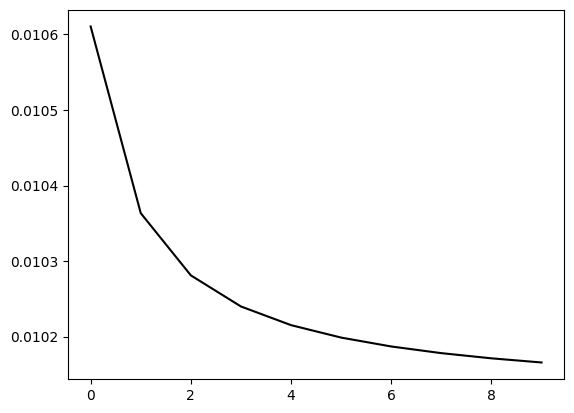

In [34]:
plt.plot(mean_loss, 'k', label = 'training')
plt.legend

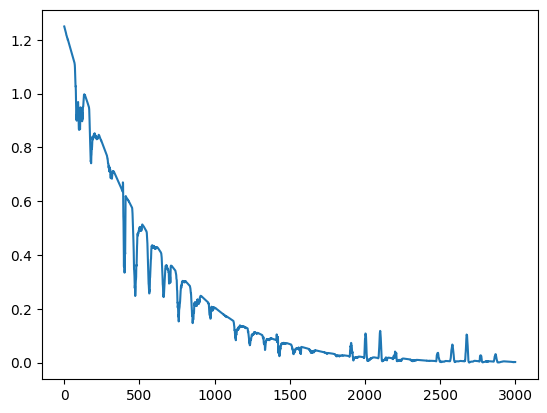

In [ ]:
plt.plot(losses[0:4000])

In [37]:
torch.save(model.state_dict(), 'HW02RNN10E.pt')